### 处理输入数据

In [3]:
# 模型输入数据处理
import pandas as pd
train = pd.read_csv('./data/train_20171215.txt', sep='\t')
# 删除 day_of_week / brand
new_df = train.drop(['day_of_week', 'brand'],axis=1).groupby('date').sum()
new_df['date'] = new_df.index
new_df = pd.merge(new_df, train[['date','day_of_week']].drop_duplicates(), how='left', on='date')
print new_df.shape
new_df.to_csv('./data/train_group.txt', sep='\t')
new_df.head(5)

(1032, 3)


,cnt,date,day_of_week
0,68,1,3
1,36,2,4
2,5565,3,5
3,4966,4,6
4,3346,5,7


**填充数据**

In [2]:
# 通过 day_of_week 发现日期数据并不连续
# 为了做时序预测，填充缺失数据，暂时填充为0后续再一起处理
def fill_missing(df):
    modi_df = pd.DataFrame(columns=['date', 'day_of_week', 'cnt'], dtype=int)
    last_day_of_week = 0
    for index, row in df.iterrows():
        now_day_of_week = row['day_of_week']
        # 若 day_of_week 当前天减上一天不是1 或 -6，说明有跳跃
        while (last_day_of_week != 0) and (now_day_of_week - last_day_of_week != 1) and (now_day_of_week - last_day_of_week != -6):
            if last_day_of_week == 7:
                last_day_of_week = 1
            else:
                last_day_of_week += 1
            modi_df = modi_df.append({'day_of_week': last_day_of_week, 'cnt': 0}, ignore_index=True)
        modi_df = modi_df.append(row, ignore_index=True)
        last_day_of_week = now_day_of_week
    return modi_df

In [3]:
modi_df = fill_missing(new_df)
print modi_df.shape
# 改变 cnt 列的值属性为数值型
modi_df.cnt = pd.to_numeric(modi_df.cnt)
# print modi_df.dtypes
modi_df.head(15)

(1192, 3)


,date,day_of_week,cnt
0,1,3,68
1,2,4,36
2,3,5,5565
3,4,6,4966
4,5,7,3346
5,6,1,3396
6,7,2,4146
7,8,3,3096
8,9,4,2713
9,10,5,2409


**使用均值（填充前的，否则会受到0的影响）填充为0的记录**

In [4]:
# import warnings 
# warnings.filterwarnings("ignore")
for i in range(1, 8):
    # 对每个 day_of_week 依次填充
    day_of_week_mean = int(new_df[new_df.day_of_week == i]['cnt'].mean())
    modi_df.loc[modi_df.day_of_week == i, 'cnt']= modi_df[modi_df.day_of_week == i].cnt.mask(modi_df.cnt == 0, day_of_week_mean)
print modi_df.head(15)

   date day_of_week   cnt
0     1           3    68
1     2           4    36
2     3           5  5565
3     4           6  4966
4     5           7  3346
5     6           1  3396
6     7           2  4146
7     8           3  3096
8     9           4  2713
9    10           5  2409
10   11           6   275
11  NaN           7   742
12   12           1  2735
13   13           2  2386
14   14           3  1901


**为现有dataframe增加ds**

In [5]:
modi_df['ds'] = pd.date_range(start = '1/2/2013', periods=1192)
# modi_df[(modi_df['ds'] >= '10/1/2014') & (modi_df['ds'] <= '10/7/2014')]
modi_df.tail()

,date,day_of_week,cnt,ds
1187,NaN,7,742,2016-04-03
1188,NaN,1,2364,2016-04-04
1189,1030,2,4003,2016-04-05
1190,1031,3,2513,2016-04-06
1191,1032,4,1306,2016-04-07


### 训练模型

**生成训练数据**

In [6]:
import numpy as np

prophet_train = modi_df.loc[:,['ds', 'cnt']]
prophet_train.rename(columns = {'cnt':'y'}, inplace = True)
# prophet_train.y = np.log1p(prophet_train.y)
prophet_train.head()

,ds,y
0,2013-01-02,68
1,2013-01-03,36
2,2013-01-04,5565
3,2013-01-05,4966
4,2013-01-06,3346


**确定预测集的大小（测试数据仍然不是连续的）**

In [ ]:
# 因为测试数据的A榜和B榜是连续时间，故若预测B榜的数据，需要先将两个测试集合并，然后选择B榜的数据
test_A = pd.read_csv('../data/test_A_20171225.txt', sep='\t')
test_B = pd.read_csv('../data/test_B_20171225.txt', sep='\t')
all_test = 

In [8]:
test_A = pd.read_csv('../data/all_test.txt', sep='\t')
modi_test_A = fill_missing(test_A)
# 改变 cnt 列的值属性为数值型
modi_test_A.cnt = pd.to_numeric(modi_test_A.cnt)
print modi_test_A.shape
# 获得向后延展多少天 (A-316)
modi_test_A['ds'] = pd.date_range(start = '4/7/2016', periods=601)
modi_test_A.tail(10)

(601, 3)


,date,day_of_week,cnt,ds
591,1570.0,7.0,NaN,2017-11-19
592,1571.0,1.0,NaN,2017-11-20
593,1572.0,2.0,NaN,2017-11-21
594,1573.0,3.0,NaN,2017-11-22
595,1574.0,4.0,NaN,2017-11-23
596,1575.0,5.0,NaN,2017-11-24
597,1576.0,6.0,NaN,2017-11-25
598,1577.0,7.0,NaN,2017-11-26
599,1578.0,1.0,NaN,2017-11-27
600,1579.0,2.0,NaN,2017-11-28


**训练&预测**

In [9]:
from fbprophet import Prophet
import pickle as pkl

with open('../data/holidays.pkl', 'rb') as rf:
    holidays = pkl.load(rf)
m = Prophet(holidays = holidays)
m.fit(prophet_train)
# future = m.make_future_dataframe(periods=50)
# A - 315
future = pd.DataFrame({'ds':pd.date_range(start='4/8/2016', periods=600)})
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
595,2017-11-24,2517.192608,1707.505968,3357.105264
596,2017-11-25,1093.248083,246.050967,1945.408897
597,2017-11-26,1361.438738,477.401280,2213.652583
598,2017-11-27,2987.141444,2120.099910,3889.437358
599,2017-11-28,3069.828702,2229.684469,3959.882702


**处理预测的数据**

In [10]:
test_A_yhat = forecast.loc[:, ['ds', 'yhat']]
# test_A_yhat.yhat = np.expm1(test_A_yhat.yhat)
# 按照 ds 与真正的测试集连接
test_A_yhat = test_A_yhat.merge(modi_test_A, on=['ds'])
# test_A_yhat.head(15)
# 过滤掉那些自己填充的
real_pre_yhat_A = test_A_yhat[test_A_yhat.date.notnull()].drop(['day_of_week', 'cnt', 'ds'],axis=1)
print real_pre_yhat_A.shape
real_pre_yhat_A.tail(15)

(547, 2)


,yhat,date
585,2855.204837,1565.0
586,2505.342854,1566.0
587,2077.713065,1567.0
588,2375.046569,1568.0
589,974.631301,1569.0
590,1270.021531,1570.0
591,2925.934114,1571.0
592,3041.081093,1572.0
593,2681.475639,1573.0
594,2239.171860,1574.0


**预测结果写入文件**

In [13]:
real_pre_yhat_A[['yhat', 'date']] = real_pre_yhat_A[['yhat', 'date']].astype(int)
real_pre_yhat_A.head()
real_pre_yhat_A.loc[:, ['date', 'yhat']].to_csv('../res/test_B_prophet_holidays.txt', sep='\t', index=False)

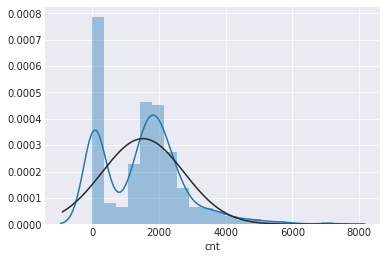

In [7]:
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm

# 填充后
sns.distplot(modi_df['cnt'], fit=norm)

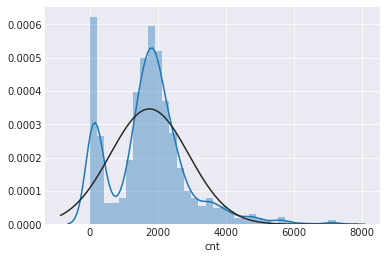

In [8]:
# 填充前
sns.distplot(new_df['cnt'], fit=norm)

In [12]:
# 填充前数值的 统计结果
new_df['cnt'].describe()

count    1032.000000
mean     1760.124031
std      1153.164214
min        12.000000
25%      1178.750000
50%      1774.000000
75%      2277.750000
max      7226.000000
Name: cnt, dtype: float64

In [16]:
# 以 MSE 作为评判标准，计算当前值的 MSE
from sklearn.metrics import mean_squared_error

mse_test = new_df
mse_test['25%'] = 1178
mse_test['50%'] = 1774
mse_test['75%'] = 2277
mse_test['median'] = mse_test['cnt'].median()
mse_test['mean'] = mse_test['cnt'].mean()
print(mean_squared_error(mse_test['cnt'],mse_test['25%']))
print(mean_squared_error(mse_test['cnt'],mse_test['50%']))
print(mean_squared_error(mse_test['cnt'],mse_test['75%']))
print(mean_squared_error(mse_test['cnt'],mse_test['median']))
print(mean_squared_error(mse_test['cnt'],mse_test['mean']))
#  好大啊！！！！

1667367.53876
1328691.6938
1595659.9186
1328691.6938
1328499.15128


In [19]:
# 以不同 day_of_week 计算平均值，计算 MSE
res = mse_test.groupby(['day_of_week'], as_index=False).cnt.mean()
xx = mse_test.merge(res,on=['day_of_week'])
print res
print mean_squared_error(xx['cnt_x'],xx['cnt_y'])
# mse 减少了一些！！！

   day_of_week          cnt
0            1  2364.100000
1            2  2495.822086
2            3  2094.787879
3            4  1625.506024
4            5  1889.317073
5            6   412.087500
6            7   742.907407
827100.639665


In [30]:
# 根据平均值生成 【第一版】 预测结果
test = pd.read_csv('../data/test_A_20171225.txt', sep='\t')
mean_res = test.merge(res, on=['day_of_week'])
mean_res.cnt = mean_res.cnt.astype(int)
mean_res.drop(['day_of_week'], axis=1, inplace=True)
print mean_res.shape
mean_res.to_csv('../res/test_mean.txt', sep='\t', index=False)

(276, 2)


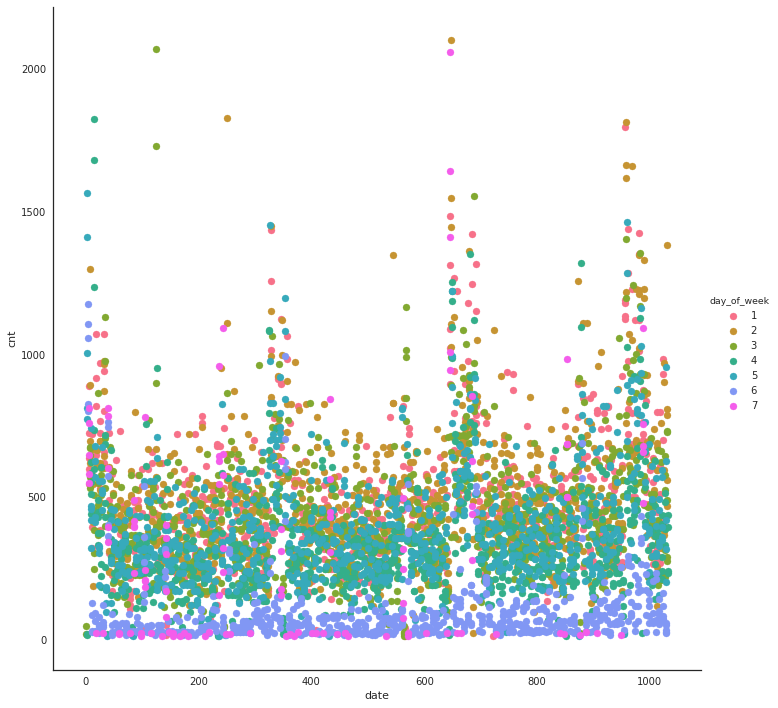

In [2]:
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

sns.set(style="white", color_codes=True)
# hue英文是色彩的意思
sns.FacetGrid(train_df, hue="day_of_week", size=10).map(plt.scatter, "date", "cnt").add_legend()

In [20]:
new_df.drop(['date'], axis=1).groupby('day_of_week').describe()

cnt                                                            \
             count         mean          std   min      25%     50%      75%   
day_of_week                                                                    
1            160.0  2364.100000   989.181863  13.0  1862.75  2138.5  2558.50   
2            163.0  2495.822086   999.493291  15.0  1910.00  2246.0  2790.50   
3            165.0  2094.787879   854.445433  23.0  1658.00  1933.0  2339.00   
4            166.0  1625.506024   878.351940  12.0  1212.00  1469.5  1849.00   
5            164.0  1889.317073   874.393264  12.0  1498.50  1753.0  2097.50   
6            160.0   412.087500   597.645794  15.0   166.00   252.0   409.00   
7             54.0   742.907407  1425.558550  13.0    19.25    24.0   962.75   

                     
                max  
day_of_week          
1            6421.0  
2            7226.0  
3            5581.0  
4            6072.0  
5            5565.0  
6            4966.0  
7            7063.0

In [21]:
modi_df.drop(['date'], axis=1).groupby('day_of_week').describe()

cnt                                                           \
             count         mean          std  min      25%     50%      75%   
day_of_week                                                                   
1            170.0  2225.035294  1109.881650  0.0  1804.00  2103.0  2508.75   
2            170.0  2393.052941  1097.723056  0.0  1891.75  2214.0  2753.25   
3            171.0  2021.286550   923.986335  0.0  1606.50  1907.0  2332.50   
4            171.0  1577.976608   907.883459  0.0  1192.00  1467.0  1799.50   
5            170.0  1822.635294   927.186619  0.0  1438.75  1719.5  2053.25   
6            170.0   387.847059   587.794836  0.0   139.00   245.5   388.00   
7            170.0   235.982353   870.434235  0.0     0.00     0.0    18.00   

                     
                max  
day_of_week          
1            6421.0  
2            7226.0  
3            5581.0  
4            6072.0  
5            5565.0  
6            4966.0  
7            7063.0

In [12]:
modi_df.to_csv('../data/fill_missing.csv', index=False)

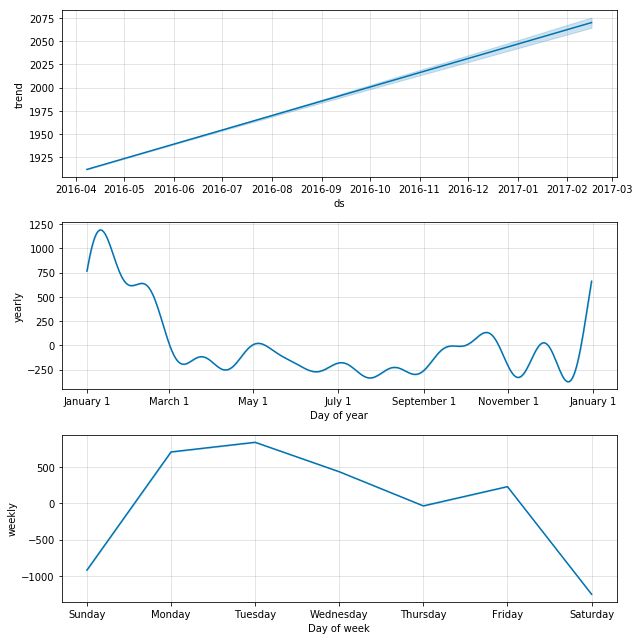

In [9]:
m.plot_components(forecast)